In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np

In [26]:
recipes_df = pd.read_csv('../data/RAW_recipes.csv.zip')
ratings_df = pd.read_csv('../data/RAW_interactions.csv.zip')

In [27]:
recipes_df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [28]:
ratings_df.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


```
8. Distribution of no of ingredients per recipe 
9. Average rating per no of ingredients
10. Average number of nutritional elements, for every rating.
```

## 8. Distribution of no of ingredients per recipe 

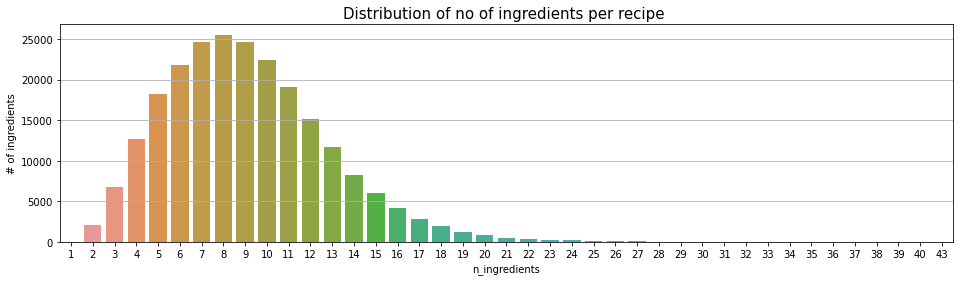

In [24]:
distribution_df = recipes_df.groupby(['n_ingredients']).size().reset_index(name='# of ingredients')
distribution_df.shape

fig = plt.figure(figsize=(16, 4))
plt.grid()
plt.title('Distribution of no of ingredients per recipe ', fontsize=15)


line_chart = sns.barplot(x='n_ingredients', y='# of ingredients', data=distribution_df)
# line_chart.set(ylim=(0, distribution_df['# of ingredients'].max()))

## 9. Average rating per number of ingredients

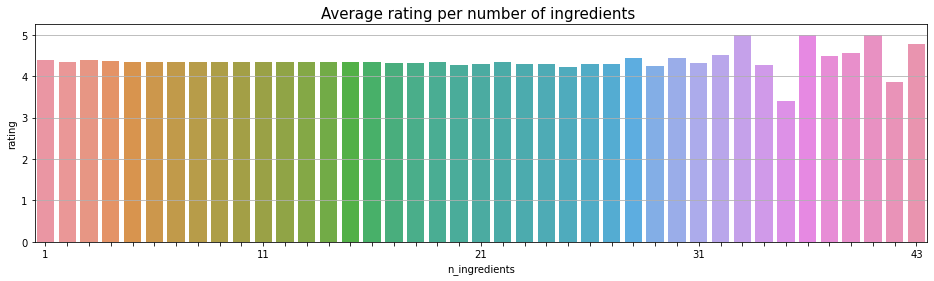

In [48]:
average_rating_per_no_ingredients = ratings_df.groupby(['recipe_id'], as_index=False)['rating'].mean()
average_rating_per_no_ingredients.rename(columns={'recipe_id': 'id'}, inplace=True)

average_rating_per_no_ingredients_m = recipes_df.merge(average_rating_per_no_ingredients, on='id')
average_rating_per_no_ingredients_m

fig = plt.figure(figsize=(16, 4))
plt.grid()
plt.title('Average rating per number of ingredients ', fontsize=15)


line_chart = sns.barplot(x='n_ingredients', y='rating', data=average_rating_per_no_ingredients_m, ci=None)

for ind, label in enumerate(line_chart.get_xticklabels()):
    if ind % 10 == 0:  # every 9th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
# line_chart.set(ylim=(0, distribution_df['rating'].max()))

In [36]:
average_rating_per_no_ingredients[average_rating_per_no_ingredients['id']==31490]

,id,rating
17031,31490,3.5


## 10. Average number of nutritional elements, for every rating.

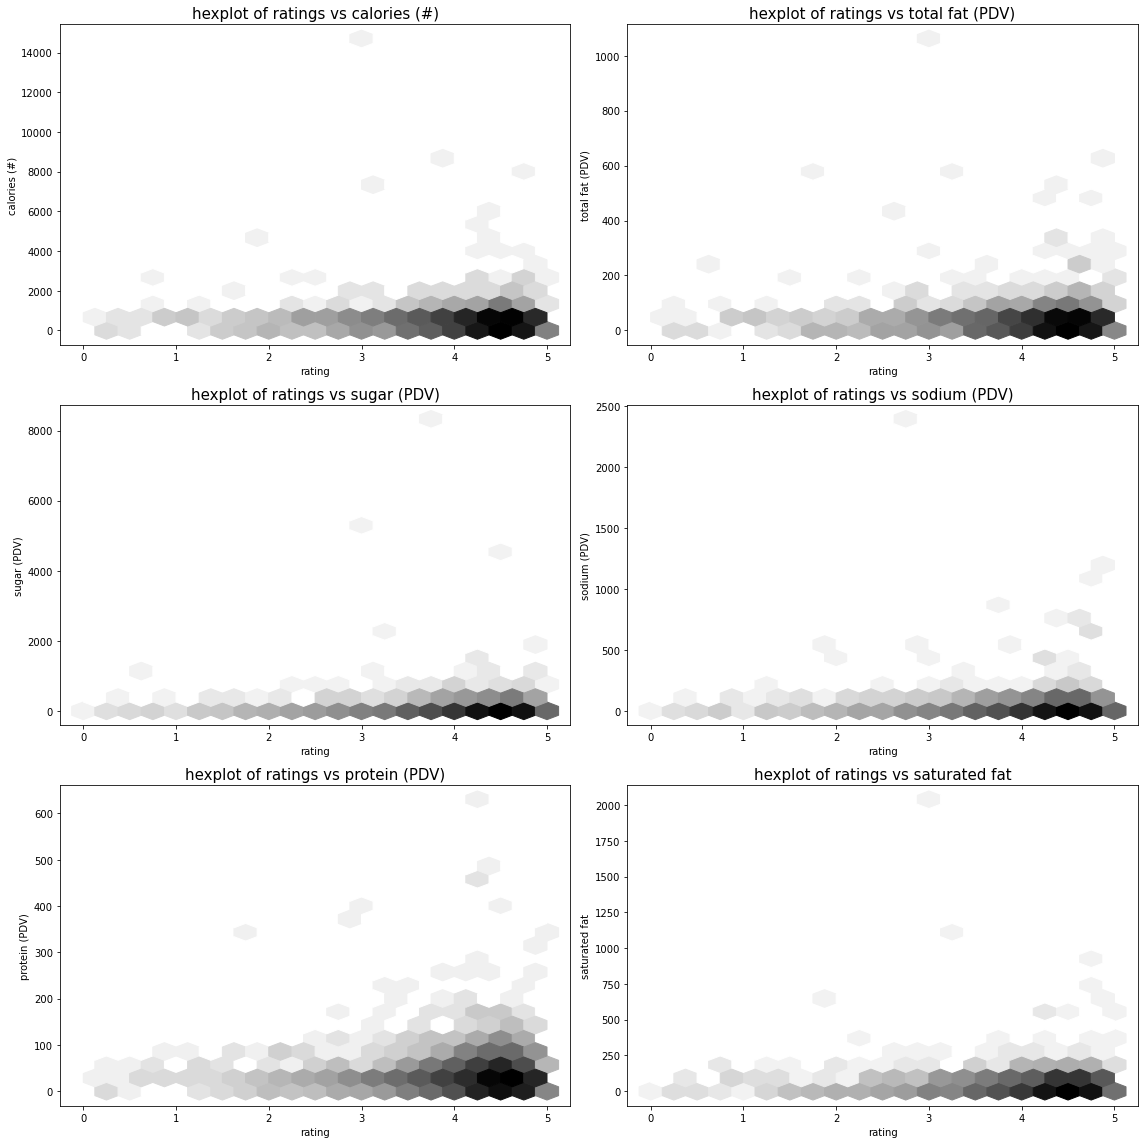

In [147]:
# average_rating_per_no_ingredients_m['nutrition'].apply(json.loads)
nutrition_info = ['calories (#)', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat']
plt.figure(figsize=(16, 16))
# nutrition_df = [{nutrition:pd.DataFrame()} for nutrition in nutrition_info]
nutrition_df = pd.DataFrame()
all_nutrition_df = pd.DataFrame()
average_rating_per_no_ingredients_m_exploded = average_rating_per_no_ingredients_m.explode("nutrition")

for index, nutrition in enumerate(nutrition_info):
    nutrition_df = average_rating_per_no_ingredients_m_exploded.groupby('id').nth(index)
    nutrition_df = nutrition_df[['rating', 'nutrition']]
    nutrition_df.astype(float)
    nutrition_df = nutrition_df.groupby(['rating'])['nutrition'].apply(np.mean).reset_index()
    if('rating' not in list(all_nutrition_df.columns.values)):
        all_nutrition_df['rating'] = nutrition_df['rating']
    all_nutrition_df[nutrition] = nutrition_df['nutrition']
    
    plt.subplot(3, 2, index+1)
    plt.title('hexplot of ratings vs ' + nutrition, fontsize=15)
    hexplot_chart = plt.hexbin(x=all_nutrition_df['rating'], y=all_nutrition_df[nutrition], gridsize=20, bins='log', cmap='Greys')
    plt.xlabel("rating", fontsize=10)
    plt.ylabel(nutrition,fontsize=10) 
    plt.tight_layout()
# all_nutrition_df


<AxesSubplot:xlabel='rating', ylabel='value'>

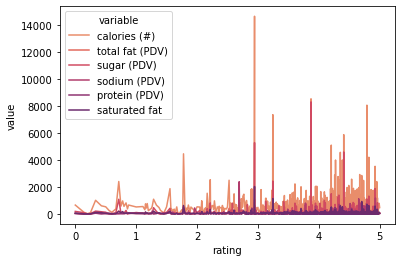

In [142]:
# sns.lineplot(x='rating', y='calories (#)', data=all_nutrition_df)
sns.lineplot(x='rating', y='value', hue='variable', palette="flare",
             data=pd.melt(all_nutrition_df, ['rating']))
# plt.yscale('log')


Text(0, 0.5, 'calories')

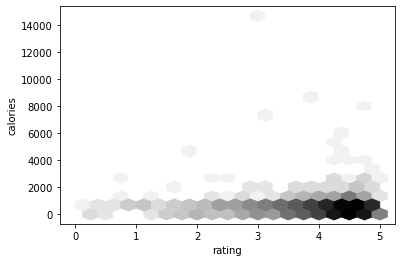

In [144]:
# plt.subplot(1, 2, 2)

